In [58]:

import os
import struct
import numpy as np
from matplotlib import pyplot

import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import csv

#Fashion-MNIST classes (mapping from class index to class name)
class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# some utilities

def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'label'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

        
def read_fMNIST(dataset = "training", path = "./", load_small=False):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    

    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X



def show_fMNIST_example(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.axis('off')
    pyplot.show()

Let's look at some images

Training images
Class: bag


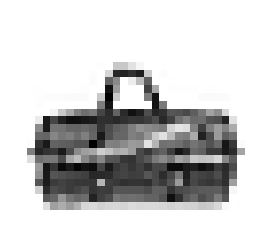

Class: shirt


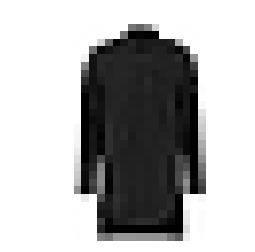

Validation images
Class: bag


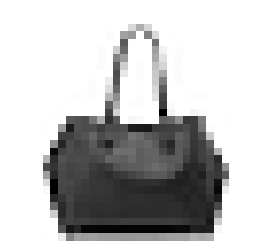

Class: sandal


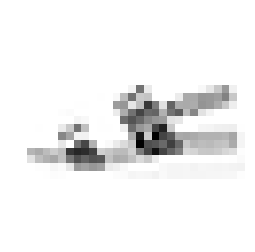

In [59]:

X,y = read_fMNIST('training')
print('Training images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])


X,y = read_fMNIST('validation')
print('Validation images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])



Now we will build the code for our softmax model

In [60]:
def softmax(scores):
    """
    takes the softmax along the second dimension of a matrix, returns class scores
    """
    # we will adjust the dynamic range by subtracting the max, to prevent potential underflow in exp
    exp_scores = np.exp(scores-np.max(scores,axis=1,keepdims=True))+1e-6
    return exp_scores/(np.sum(exp_scores,axis=1,keepdims=True))


def log_likelihood(X,w,y):
    """
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapont with d features
      Y: a Nx10 matrix, each row is a one-hot vector with the ith entry is 1 if that datapoint belongs to class i 
      w: is a dx1 matrix containing your model parameters
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    scores = infer(X,w)
    predictions = softmax(scores)
    likelihoods = np.sum(predictions * y, axis=1, keepdims=True)
    LL = np.mean(np.log(likelihoods))

    return LL

def objective(X,w,y):
    """
    Compute components of the optimization objective
    Output:
    logloss : value of log-loss (negative average log-likelihood)
    regularizer: value of the regularization term (Frobenius norm of w), NOT multiplied by lambda
    """
    regularizer = np.linalg.norm(w,'fro')
    logloss = - log_likelihood(X,w,y)
    return logloss, regularizer



def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*norm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective is -log p(y|X;w) + lmbda*norm2(w)
    """
    
    #Compute any extra variable needed to compute the gradient:
    scores = np.dot(X,w)
    predictions = softmax(scores)

    #Compute the gradient of the average log-loss
    grad = (X.transpose().dot(predictions-y)) / X.shape[0]
    
    l2grad = 2 * w
    
    return grad, l2grad

def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    """
    scores = np.dot(X,w)
    return scores

def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc

def compute_confusion(val_preds,correct_preds):
    dim_of_confusion_matrix = 10
    confusion_matrix = np.zeros((dim_of_confusion_matrix,dim_of_confusion_matrix))
    for index, val in enumerate(val_preds):
        confusion_matrix[correct_preds[index]][val] = 1 + confusion_matrix[correct_preds[index]][val]
        '''
        if val_correct == val:
            confusion_matrix[index_correct, index] =+ 1
        else:
            confusion_matrix[index_correct,index] =+ 0
        '''
    return confusion_matrix
                    

Now we define the SGD (stochastic gradient descent) procedure for softmax, with optional regularization

In [61]:
def minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    
    # initialization of w (feel free to play with this)
    w = np.zeros((xTr.shape[1],yTr.shape[1]))
    
    old_obj = 1e9  
    old_w = w
    
    # we will organize the run in terms of epochs (one epcoh = one full pass over data)
    # to keep track of learning curves, allocate space
    trAcc = np.zeros(maxepochs)
    obj = np.zeros(maxepochs)
    
    for epoch in range(maxepochs):
        
        #shuffle the data
        index = np.random.permutation(xTr.shape[0])
        nBatches = np.floor(xTr.shape[0]/bsize).astype(np.integer) # ignore the remainder N-floor(N/bsize), for simplicity
    
        for b in range(nBatches):
            # fill in the batch
            iBatch = index[b*bsize:(b+1)*bsize]
            xBatch = xTr[iBatch]
            yBatch = yTr[iBatch]
            
            grad,l2grad = gradient(xBatch,w,yBatch)
    
            w = w-lr*(grad+lmbda*l2grad)
            
        
        # end of an epoch: test for convergence by looking at validation
        logloss, regularizer = objective(xTr,w,yTr)
        obj[epoch] = logloss+lmbda*regularizer
                
        # also record accuracy on training
        trAcc[epoch] = accuracy(xTr,w,yTr)

        obj_gain = (old_obj-obj[epoch])/np.abs(old_obj) # improvement in training objective this epich
        
        if verbose > 0.5:
            print('Epoch %d: obj=%.4f, gain %.4f  [train acc %.4f]'%(epoch,obj[epoch],obj_gain,trAcc[epoch]))
        
        
        if epoch == maxepochs-1:
            if verbose > 0:
                print('Reached max epochs, stopping')
            return w, obj, trAcc
        
        if obj_gain < objTol:  
            lr = lr/2
            if verbose > 0:
                print('Dropping learning rate to %.4f'%lr)
        
        # update bookkeeping before going to next epoch
        old_obj = obj[epoch]    
    

Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel.

In [62]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X,mu = None,sigma = None,visualize=False):

    if visualize:
        print('VISUALIZE BEFORE NORMALIZATION')
        #Visualize example before normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if mu is None: # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[np.equal(sigma,0)]=1.0 # avoid division by zero in case of degenerate features
    else:
        compute_stats = False
        
    #Normalize the data
    X = (X-mu)/sigma
    bias_feature = np.ones((X.shape[0],1))
    X = np.concatenate([np.ones((X.shape[0],1)),X],1)

    if visualize:
        print('VISUALIZE AFTER NORMALIZATION')
        #Visualize example after normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if compute_stats:
        return X, mu, sigma
    else:
        return X




VISUALIZE BEFORE NORMALIZATION


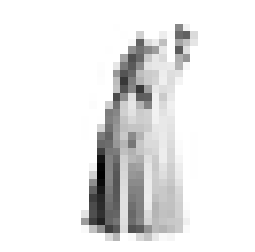

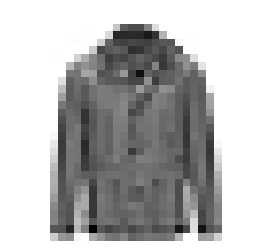

VISUALIZE AFTER NORMALIZATION


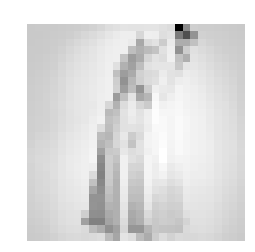

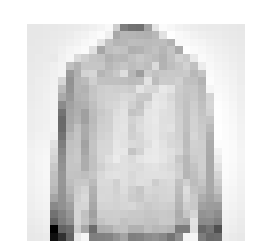

In [63]:
xTr, yTr = read_fMNIST('Training')
xTr, mu, sigma = preprocess_data(xTr,visualize=True)

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [64]:
# run minibatch SGD for every value of lambda and record training/val accuracy
def tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt):
    
    obj=dict()
    trAcc=dict()
    model=dict()
    valAcc=dict()

    for lmbda in lambdas:
        model[lmbda], obj[lmbda],trAcc[lmbda] = minibatch_sgd(xTr,yTr,xVl,yVl,lmbda, sgd_opt['lr'],sgd_opt['maxepochs'],sgd_opt['bsize'],verbose=sgd_opt['verbose'])
        valAcc[lmbda] = accuracy(xVl,model[lmbda],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,valAcc[lmbda],trAcc[lmbda][-1]))
        
    return model, obj, trAcc, valAcc

In [65]:
xTr, yTr = read_fMNIST('Training')
xVl, yVl = read_fMNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

# values below are a recommendation for initial exploration -- you should see if you want to refine these

lambdas = [0,.0001,.001,.01,.1,1.0,10.0]
sgd_opt = {'bsize':16, 'maxepochs':20, 'lr':.1,'verbose':0}


model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

best = max(valAcc, key=valAcc.get)
print (valAcc[best])

-------------- lambda=0.00000, val Acc = 0.8507  (tr Acc = 0.8820)
-------------- lambda=0.00010, val Acc = 0.8492  (tr Acc = 0.8825)
-------------- lambda=0.00100, val Acc = 0.8544  (tr Acc = 0.8763)
-------------- lambda=0.01000, val Acc = 0.8493  (tr Acc = 0.8592)
-------------- lambda=0.10000, val Acc = 0.8169  (tr Acc = 0.8238)
-------------- lambda=1.00000, val Acc = 0.7427  (tr Acc = 0.7482)
-------------- lambda=10.00000, val Acc = 0.6714  (tr Acc = 0.6770)
0.8544


Select the best model and use it to generate predictions for test data (to be submitted to Kaggle)

In [66]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./large_submission.csv', final_preds)

[[ 762.    1.   21.   50.    5.    1.   93.    1.    9.    0.]
 [   3.  946.    4.   17.    1.    0.    2.    0.    0.    0.]
 [  18.    3.  806.   13.  121.    0.   71.    1.    4.    1.]
 [  38.    5.    6.  880.   36.    1.   25.    0.    1.    1.]
 [   2.    1.   88.   43.  787.    0.   91.    2.    5.    0.]
 [   1.    0.    1.    1.    0.  929.    0.   40.    9.   19.]
 [ 142.    5.  114.   29.   86.    0.  630.    0.   14.    0.]
 [   0.    0.    0.    0.    0.   41.    0.  928.    4.   43.]
 [  10.    1.    6.    9.    2.    9.   24.    5.  951.    3.]
 [   0.    1.    0.    0.    0.   17.    0.   33.    2.  925.]]


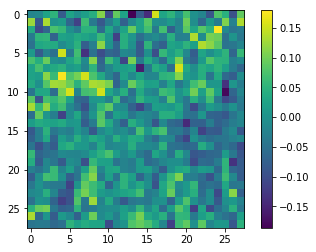

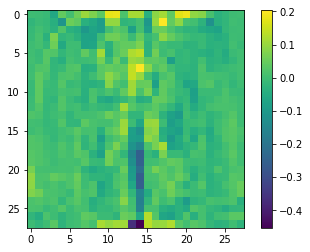

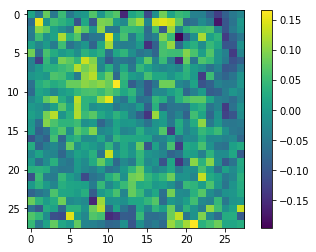

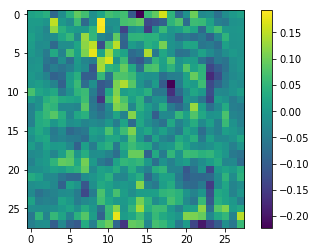

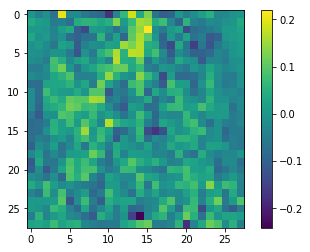

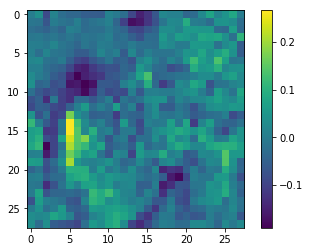

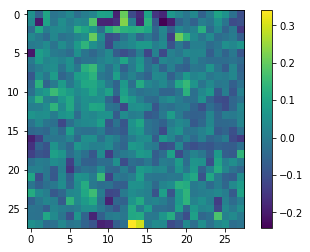

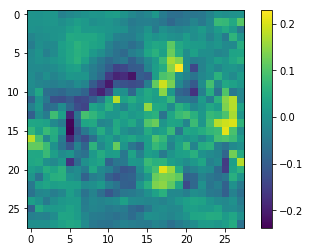

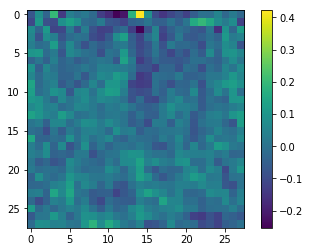

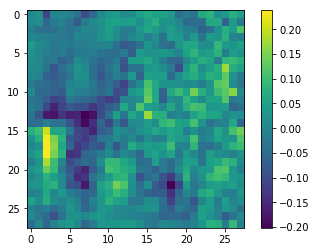

In [67]:
##Stats and Confusion Matrix on the large data set plus Plot!
#Train accuracy
# 0.8763
#Validation accuracy
# 0.8544

np.set_printoptions(suppress=True)
val_preds = np.argmax(infer(xVl,chosen_model),axis =1)
y_label = np.argmax(yVl,axis = 1)

#Confusion Matrix: PS: In the discussion section of canvas it was said that we only needed to display the validation cm
confusion_matrix_val = compute_confusion(val_preds, y_label)
print(confusion_matrix_val)
#Data points correctly classified
correct_classified_pts_val = np.trace(confusion_matrix_val)

#Validation Accuracy
validation_accuracy = (correct_classified_pts_val/float(val_preds.shape[0]))*100

w = chosen_model
for i in range(10):
    plt.imshow(w[1:,i].reshape(28,28))
    plt.colorbar()
    plt.show()

Now we will repeat this experiment with the small training set

In [46]:
xTr, yTr = read_fMNIST('Training', load_small=True)
xVl, yVl = read_fMNIST('Validation')


xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

lambdas = [0,.0001,.001,.01,.1,1.0,10.0]
sgd_opt = {'bsize':3, 'maxepochs':30, 'lr':.1,'verbose':0}


model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

best = max(valAcc, key=valAcc.get)
print (valAcc[best])

-------------- lambda=0.00000, val Acc = 0.4963  (tr Acc = 1.0000)
-------------- lambda=0.00010, val Acc = 0.5257  (tr Acc = 1.0000)
-------------- lambda=0.00100, val Acc = 0.5404  (tr Acc = 1.0000)
-------------- lambda=0.01000, val Acc = 0.5169  (tr Acc = 1.0000)
-------------- lambda=0.10000, val Acc = 0.5635  (tr Acc = 1.0000)
-------------- lambda=1.00000, val Acc = 0.5717  (tr Acc = 1.0000)
-------------- lambda=10.00000, val Acc = 0.5499  (tr Acc = 0.9667)
0.5717


In [47]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./small_submission.csv', final_preds)


[[ 578.    6.   61.  130.   35.   79.   43.    4.    7.    0.]
 [  19.  882.   17.   24.    8.    8.   14.    0.    1.    0.]
 [  11.    5.  432.    2.  166.  180.  231.    0.   11.    0.]
 [  90.  148.   15.  531.  110.   86.   11.    0.    2.    0.]
 [   9.   18.  192.    9.  572.  106.  108.    1.    4.    0.]
 [   2.    0.    5.    0.    0.  623.    3.  318.   15.   34.]
 [ 154.    2.  188.   47.  178.  233.  197.    5.   15.    1.]
 [   0.    0.    0.    0.    0.   74.    0.  917.   14.   11.]
 [  66.    2.   31.   11.   19.   93.   34.  234.  519.   11.]
 [   1.    1.   39.    1.    0.  127.    1.  211.  131.  466.]]


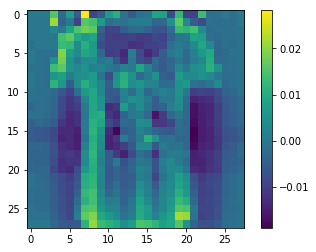

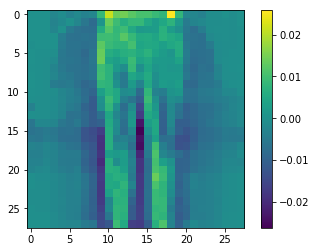

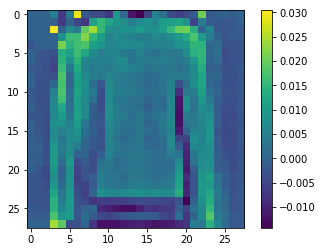

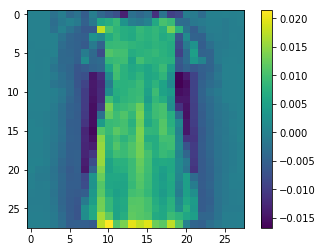

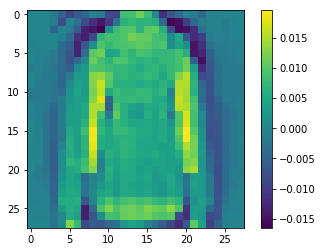

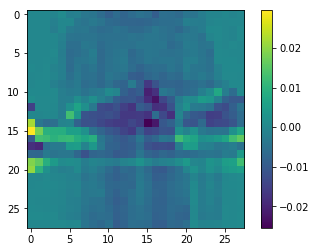

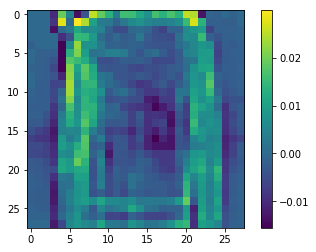

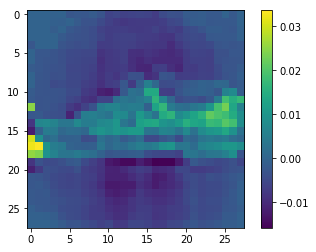

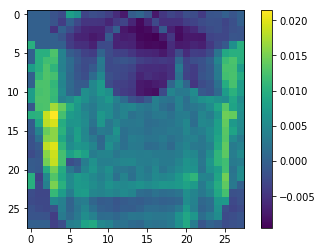

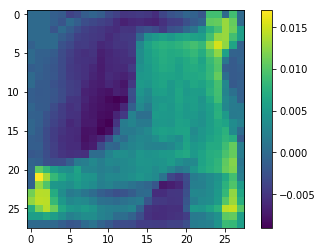

In [53]:
##Stats and Confusion Matrix on the small data set plus Plot!
#Train accuracy
# 0.5717
#Validation accuracy
# 1

np.set_printoptions(suppress=True)
val_preds = np.argmax(infer(xVl,chosen_model),axis =1)
y_label = np.argmax(yVl,axis = 1)

#Confusion Matrix: PS: In the discussion section of canvas it was said that we only needed to display the validation cm
confusion_matrix_val = compute_confusion(val_preds, y_label)
print(confusion_matrix_val)
#Data points correctly classified
correct_classified_pts_val = np.trace(confusion_matrix_val)

#Validation Accuracy
validation_accuracy = (correct_classified_pts_val/float(val_preds.shape[0]))*100

w = chosen_model
for i in range(10):
    plt.imshow(w[1:,i].reshape(28,28))
    plt.colorbar()
    plt.show()



In [ ]:
#Analysis
The weights for the small data set make the imagines resemble clothing because they are closer to the actual values
of the images. Therefore its ability to classify new images is smaller.
Since the larger dataset introduces much more training input to the model its output weights do not
reseamble the clothing images as well, since the weight values are trying to generalize the inputs to predict possible
outcomes for future values.

The effect of the regularization on the large dataset can be analyzed from 2 standpoints of view, 
the training accuracy and the validation accuracy. The training accuracy decreases monotonically as we increase the value of lambda,
i.e. we increase the effect of the regularization. When it comes to the validation accuracy, it reaches a maximum
at lambda=0.001 which means that it reseambles a convex function on the interval analysed. The validation and training
accuracies were similar which means that the variance is small so the need for a regularization is not as pronouced as in
the smaller dataset

When it comes to the small dataset, the small number of observations analysed led to the overfitting of the model. 
The validation accuracy had much smaller values when compared to the larger set and the difference between the training
accuracy was much larger than on the large dataset. This means that the variance is large and the regularization can
be used to reduce its value.